# Lab 4: Resampling & Randomization Methods

In this lab we will get more comfortable setting up various classifiers in r.

## Goals of the lab:
* Learn to use the cv.glm() function
* Learn to use the boot() function
* Learn to write _for loops_ to do permutation tests

This lab draws from the practice sets at the end of Chapter 5 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

----
# Validation data sets

Here we will explore test error rates using cross-validation. We'll be using the Auto data set again from the ISLR library. 

First, we should acknowledge that you'll need to reset the seed for your random number genrator. For this use the [_set.seed()_](https://www.rdocumentation.org/packages/simEd/versions/1.0.3/topics/set.seed) function. We want to use the same seed as the book so that you get the same results.

In [17]:
library(ISLR)
set.seed(1)
train=sample(392,196) 

Above we just set a training set to take 196 unique random samples out of a list ranging from 1-392. This will identify our random training set.

In [18]:
train

[1] 105 146 224 354  79 348 365 255 242  24 388  68 262 391 292 188 270 372
 [19] 143 290 387 382 384  47  99 142   5 140 317 124 175 217 178  67 297 239
 [37] 283  39 257 379 289 228 275 194 185 274   9 165 252 238 164 294 149  83
 [55] 383  34 107 174 222 136 304  98 152 110 214  85 157 250  28 356 329 376
 [73] 111 336 330 323 347 123 245 301 333 334 363 101 234  63 218  38  75  44
 [91]  73  18 193 263 233 237 135 121 357 360 192 103 371 287 183  62 305 137
[109] 299 170 276 206 100 295  42   4 198  29 315 362 321 296 131 369 203 122
[127] 312  55  61 326 151  21  10 167 240 154 144 271 251 129 173 380  60  65
[145] 181 112 303 288  26 211 340 385 373 109 120  43 125 313 249  50 359 207
[163] 291 179 201  94  15  76 163 225 386 186 189  86 339 195 311 160 130 300
[181] 307  41 187 106 314  40 284 370 213 247 256 258 261 375  57 117

Now let's fit some models doing the trainig-testing approach that we've used so far in this class.

In [19]:
attach(Auto)

# Generate a linear model using the training subset
lm.fit = lm(mpg~horsepower, data=Auto, subset=train)
mean((mpg-predict(lm.fit,Auto))[-train]^2) # Mean Squared Error (MSE)

# Use the poly() function to estimate test error
# for polynomial and cubic regressions
# 2nd degree polynomial
lm.fit2 = lm(mpg~poly(horsepower,2), data=Auto, subset=train)
mean((mpg-predict(lm.fit2,Auto))[-train]^2) # Mean Squared Error (MSE)

# 3rd degree polynomial
lm.fit3 = lm(mpg~poly(horsepower,3), data=Auto, subset=train)
mean((mpg-predict(lm.fit3,Auto))[-train]^2)



The following objects are masked from Auto (pos = 3):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year

The following objects are masked from Auto (pos = 4):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year

The following objects are masked from Auto (pos = 5):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year

The following objects are masked from Auto (pos = 6):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year

The following objects are masked from Auto (pos = 7):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year



[1] 26.14142

[1] 19.82259

[1] 19.78252

So for the MSE we get for the linear and the two polynomial models (quadratic & cubic) is 26.14, 19.82, and 19.78 respectively. But these exact values are sensitive to the particular subset we selected. Let's repeat this selecting a different subset of the Auto data.

In [20]:
# Notice that if we use a different subsample we'd get different results
set.seed(2) # always reset the seed
train=sample(392,196)
train

[1]  73 275 224  66 367 366  50 321 180 211 212  92 289  69 154 322 368  85
 [19] 167  28 247 144 310  56 128 384  55 131 351  49   4  60 292 312 185 390
 [37] 301 102 237  54 346 105  41  57 329 276 338 121 173 278   3   6 233 316
 [55]  94 274 265 332 206 354 256 294 207  86 282 371 127 150  71  22  89 100
 [73]  14  59 319 240 381 337 326 388 110 209   8 124  62 263 298  99 223 104
 [91] 295 120 114 168 139 318 314 373  34 129 297 125 285 317  83 172 258 130
[109]  42  37   7 330 364 161 230 226 241  31 262 156  11  67 336 239  65 203
[127] 325  81 184 377 387 380 341 250  82 287 137 311  48 355  45  72 158  75
[145] 111 181 165  77 117 324 252  87 217  95 186  68 202 350  19 379 195 219
[163] 272 174 333 148  20 220 362 345 215  23 349 197 375 344  76  30 140 116
[181] 201 304 382 164  25 229  18 378 320  16 323 286 232  33 385  40

In [21]:
# Linear model
lm.fit = lm(mpg~horsepower, data=Auto, subset=train)
mean((mpg-predict(lm.fit,Auto))[-train]^2)

# Polynomial
lm.fit2 = lm(mpg~poly(horsepower,2), data=Auto, subset=train)
mean((mpg-predict(lm.fit2,Auto))[-train]^2)

# Cubic
lm.fit3 = lm(mpg~poly(horsepower,3), data=Auto, subset=train)
mean((mpg-predict(lm.fit3,Auto))[-train]^2)

[1] 23.29559

[1] 18.90124

[1] 19.2574

Notice that we get fundamentally different values with a different training subset. _This is the foundational idea of randomization methods._

---
# Leave one out cross-validation (LOOCV)

The [_boot_](https://cran.r-project.org/web/packages/boot/boot.pdf) library in r gives you a lot of the tools to do LOOCV and bootstrapping using any model fit object. Let's play with LOOCV using the _glm()_ function and the _cv.glm()_ function.

Here let's start with a simple linear regression model predicting _mpg_ from _horsepower_ using the full data set.

In [22]:
# Continue with the Auto example
glm.fit = glm(mpg~horsepower, data=Auto)
coef(glm.fit)

(Intercept)  horsepower 
 39.9358610  -0.1578447

Now let's use LOOCV, via the _cv.glm()_ function, to estimate the cross validated MSE a per the equation 5.1 in the book.

$$ CV_{(n)} = \frac{1}{n} \sum_{i=1}^{n} MSE_i $$

(Notice that if you don't define _k_ in the _cv.glm()_ function, the default is LOOCV.)

In [30]:
# Load the bootstrap library
library(boot)
glm.fit = glm(mpg~horsepower, data=Auto)
cv.err  = cv.glm(Auto, glm.fit)
cv.err$delta

[1] 24.23151 24.23114

Here the first entry of _cv.err$delta_ is the raw cross-validation estimate of prediction error (equation above) and the second is the adjusted cross-validation estimate designed to compensate for the bias introduced by not using leave-one-out cross-validation

Let's take a look at the same thing but with a polynomial regression.

In [31]:
# Repeat for polynomial models up to a factor of 5
cv.error = rep(0,5) # Always have to specify your output object
for (i in 1:5){
    glm.fit=glm(mpg~poly(horsepower,i), data=Auto)
    cv.error[i] = cv.glm(Auto, glm.fit)$delta[1]
}
cv.error

[1] 24.23151 19.24821 19.33498 19.42443 19.03321

The first entry in the _cv.error_ array is the linear model we estimated above. Notice that we get an initial improvement in accuracy when you move to the 2nd order polynomial, but more complex models (i.e., higher order polynomials) don't help much.

---
# K-fold cross validation

As stated avove, the default _k_ for the _cv.glm()_ function is _k=n_ (i.e., LOOCV). If you don't want to do LOOCV you can specify the number of folds as an input to the function.


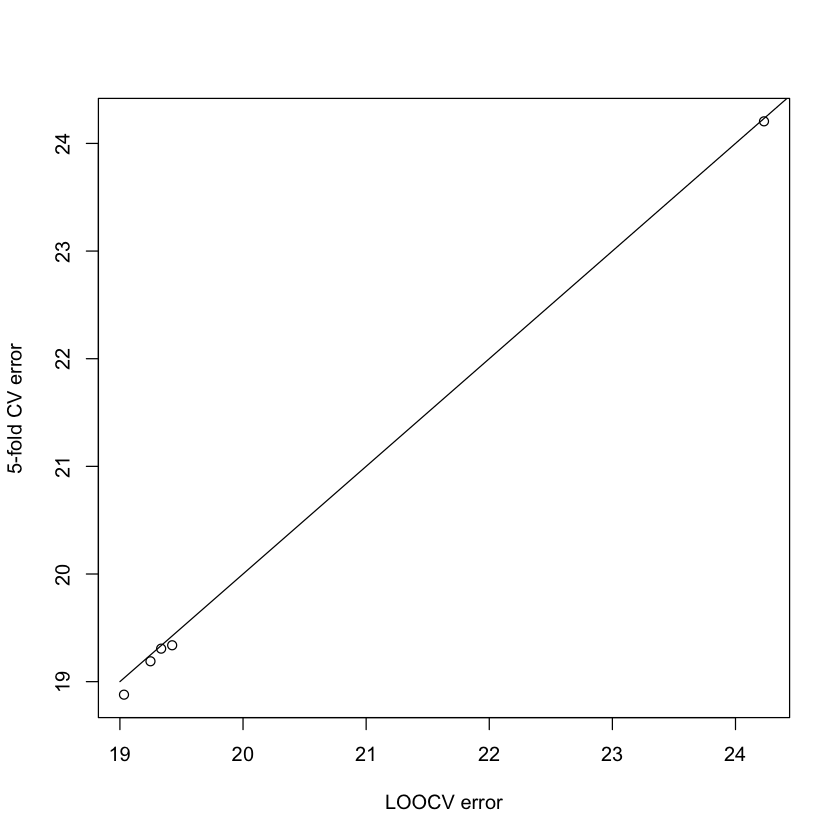

In [59]:
# Reset the seed
set.seed(17)

# Repeat our previous loop  but use K-fold CV 
# where K = 10 and up to a 5th order polynomial
cv.error.10 = rep(0,5) # Always have to specify your output object
for (i in 1:5){
  glm.fit=glm(mpg~poly(horsepower,i), data=Auto)
  cv.error.10[i] = cv.glm(Auto, glm.fit,K=10)$delta[1]
}

plot(cv.error, cv.error.10, xlab="LOOCV error", ylab="5-fold CV error")
lines(c(19,25),c(19,25))


Notice how similar the results are for 5-fold CV & LOOCV, but the folding results run faster! 

---
# Bootstrapping

Moving on from cross-validation approaches, we'll now turn to how to bootstrap confidence intervals on your results. We'll stick with the Auto data set for this.

For the bootstrap we'll want to write our own functions. There are examples of thisin the lecture notes on this topic. Here we'll look at a different (and more efficient) approach. 

First define a function that takes two inputs (a data set and an index of observations) and returns the parameter of interest. For this example, we'll return the regression coefficients for the model predicting _mpg_ from _horsepower_. 

In [60]:
# The funciton needs two inputs: Data, Index
boot.fn = function(data, index)
  # return: throw this as output
  # coef: extract coefficients from model object
  return(coef(lm(mpg~horsepower, data=data, subset=index)))

Let's test this to make sure it works. We'll use an index array that takes all 392 observations (rows) in the data set.

In [61]:
boot.fn(Auto, 1:392)

(Intercept)  horsepower 
 39.9358610  -0.1578447

Notice this is the same output as when you just run the _lm()_ function with no subset selection.

In [62]:
coef(lm(mpg~horsepower, data=Auto))

(Intercept)  horsepower 
 39.9358610  -0.1578447

Now we can use the _boot()_ function, included in the _boot_ library, to iterate through randomly sample _with replacement_ to generate a confidence interval on the regression coefficient. We'll just test it out with 1000 iterations (set using the _R_ value as an input)

In [63]:
boot(Auto ,boot.fn ,R=1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original       bias    std. error
t1* 39.9358610  0.014353249 0.829515464
t2* -0.1578447 -0.000297393 0.007231488

Here the standard error estimate of the two regression coefficients (one for the intercept and one for _horsepower_) are calculated from the 1000 bootstrapped experiments on the data set. We can see the output from each of the 1000 iterations as well (below we'll plot just for $\hat{\beta}_{horsepower}$.

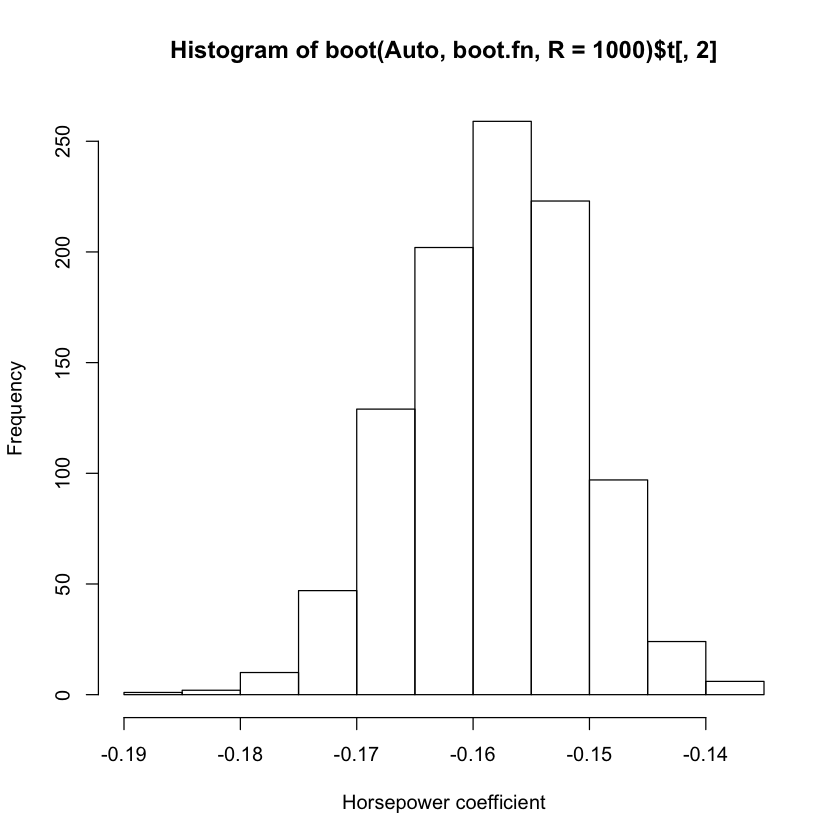

In [75]:
hist(boot(Auto ,boot.fn ,R=1000)$t[,2], xlab="Horsepower coefficient")

Now let's compare these results from the original model where we don't bootstrap.

In [77]:
# Bootstrap
boot(Auto ,boot.fn ,R=1000)

# Parametric model
summary(lm(mpg~horsepower ,data=Auto))$coef


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0232103863 0.870220505
t2* -0.1578447 -0.0003084367 0.007663235

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


Notice that they produce qualitatively similar results in this case (i.e., when the data fit the assumptions of the parametric linear regression model).

---
# Permutation tests

Remember, that the goal of permutation tests is to use resampling _without replacement_. Basically you define the specific null that you want to test and generate a random relationship with which to calculate $P(X|H_0)$. For this we can just use a simple _for_ loop. But first, we need to define what our null is. Here let's define our null as being that there is no relationship between _horsepower_ and _mpg_. In other words
$$H_0 : \hat{\beta}_{horsepower} = 0$$

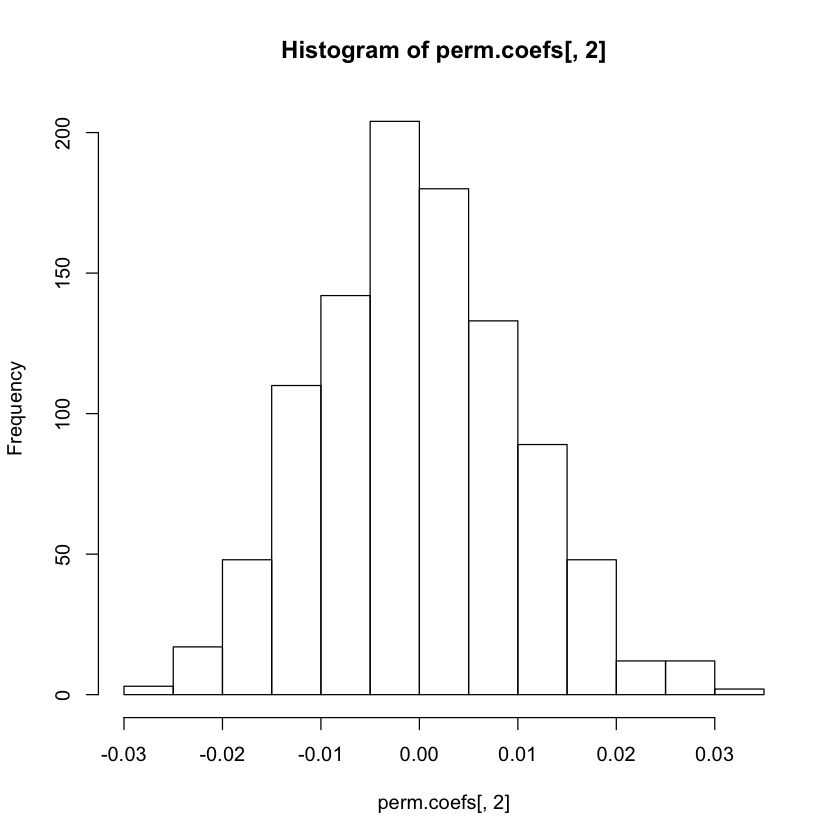

In [84]:
# First let's make a copy of the data set that we'll keep permuting
permAuto = Auto

# Set the number of iterations
R=1000

# Next smake an output object to store the results
perm.coefs=matrix(NA,nrow=R, ncol=2)

# Now just write a for loop where we scramble the observations
# in X using the sample() function
for (i in 1:R){
  permAuto$horsepower=Auto$horsepower[sample(392)]
  perm.coefs[i,]=coef(lm(mpg~horsepower, data=permAuto))
}

# Take a look at the null distributions
hist(perm.coefs[,2])


In [86]:
# Now re-estimate the real (unpermuted) effect 
perm.real = coef(lm(mpg~horsepower, data=Auto))
perm.real

(Intercept)  horsepower 
 39.9358610  -0.1578447

Notice that the real effect (-0.16) is _much_ seems to fall outside the range of values in our empirically derived distribution. But let's empirically calculate the probability of observing a stronger (i.e., more negative) effect.

In [88]:
# Since the real effect of X (B1) is negative, we want to know
# the probabilty of observing a stronger negative effect
# just due to chance.
perm.p = sum(perm.coefs[,2]<perm.real[2])/R
perm.p

[1] 0

So we do not see any permuted models that are stronger than the actual model. Now since a _p-value_ cannot technically be zero, we usually would report this as being less than a very small value (e.g., "_p<0.0001"_).
